# Simulation of Chemotaxis System in *Escherichia coli*

In [2]:
import tellurium as te

Just to be clear: this Antimony model of the bacterial chemotaxis system is purely a **personal interest** project—it’s **not** part of any formal academic research, published work, or institutional study. I put it together for fun, using data and model from Bitbol and Wingreen (2015), but it **hasn’t** undergone peer review, experimental validation, or formal parameter optimization beyond basic consistency checks. It’s just a casual exploration of the system’s dynamics, meant for my own learning and curiosity. I used AI to help me in some part of the realization below.

The values of total cellular concentrations (Bitbol & Wingreen, 2015).
| Protein | Total concentration (μM) | Notes and references |
|---------|---------------------------|----------------------|
| CheA    | 2.97                      | 1/6 of the chemoreceptor concentration, 17.8 μM (20). |
| CheY    | 9.73                      | (20)                 |
| CheZ    | 3.80                      | (20)                 |
| CheB    | 0.28                      | (20)                 |
| CheR    | 0.17                      | (20)                 |
| FliM    | 1.43                      | (21, 22). The 16% of FliM that are free (24) are discounted. |

## Realizing model from Bitbol and Wingreen (2015)

In [32]:
r = te.loada("""
model chemotaxis_system

    # Cellular concentrations from the paper
    CheA_tot = 2.97
    CheY_tot = 9.73
    CheZ_tot = 3.80
    CheB_tot = 0.28
    CheR_tot = 0.17
    FliM_tot = 1.20

    # Explicit initial concentrations
    CheA = 2.80        # Free CheA (minimize initial CheA-P, maximize alpha regulation space)
    CheA_P = 0.17      # Initial CheA-P (only 5.7% of total, alpha=0.25 baseline)
    CheY = 2.00        # Free CheY (minimize initial free fraction, <25% of CheY_tot)
    CheY_P = 2.50      # Initial CheY-P (high baseline, 25.7% of CheY_tot)
    CheZ = 3.00        # Free CheZ (reduce binding rate, minimize CheZ-CheY_P complex)
    CheZ_CheY_P = 0.80 # CheZ-CheY_P complex (only 21% of CheZ_tot)
    CheB = 0.27        # Free CheB (minimize CheA-P consumption by CheB)
    CheB_P = 0.01      # Initial phosphorylated CheB (negligible)
    FliM = 0.90        # Free FliM (reduce binding rate, minimize FliM-CheY_P)
    FliM_CheY_P = 0.30 # FliM-CheY_P complex (only 25% of FliM_tot)

    # Defining species
    species CheA, CheA_P, CheY, CheY_P, CheZ, CheZ_CheY_P, CheB, CheB_P, FliM, FliM_CheY_P

    # Conservation relations
    CheA_tot = CheA + CheA_P                              # CheA
    CheY_tot = CheY + CheY_P + FliM_CheY_P + CheZ_CheY_P  # CheY
    FliM_tot = FliM + FliM_CheY_P                         # FliM
    CheZ_tot = CheZ + CheZ_CheY_P                         # CheZ
    CheB_tot = CheB + CheB_P                              # CheB

    # Parameters
    alpha = 0.25           # CheA Adaption
    kA_cat = 60            # CheA Autophosphorylation (s⁻¹)
    kA_aY = 15             # CheA-P Phosphorylating CheY (μM⁻¹s⁻¹)
    kA_aB = 0.1            # CheA-P Phosphorylating CheB (μM⁻¹s⁻¹)
    kY_h = 0.001           # CheY-P Autodephosphorylation (s⁻¹)
    kZ_cat = 10            # CheZ Desphosphorylating CheY (s⁻¹)
    kZ_a = 0.5             # CheZ Binding with CheY-P (μM⁻¹s⁻¹)
    kZ_d = 10              # CheZ-CheY-P Unbinding (s⁻¹)
    kM_a = 2.5               # FliM Binding with CheY-P (μM⁻¹s⁻¹)
    kM_d = 5               # FliM-CheY-P Unbinding (s⁻¹)
    kB_a = 0.1             # CheA-P Binding with CheB (μM⁻¹s⁻¹)
    kB_h = 0.1             # CheB-P Autodephosphorylation (s⁻¹)

    # Dynamics
    J_CheA_P: CheA -> CheA_P; alpha * kA_cat * CheA - (kA_aY * CheY + kA_aB * CheB) * CheA_P
    # CheY-P generation: ultra-efficient (kA_aY=15)
    J_CheY_P: CheY -> CheY_P; kA_aY * CheA_P * CheY
    # CheY-P consumption: minimal and reasonable (only two paths)
    J_CheY_P_decay1: CheY_P -> CheY; kZ_cat * CheZ_CheY_P  # CheZ-catalyzed (slow)
    J_CheY_P_decay2: CheY_P -> CheY; kY_h * CheY_P         # Spontaneous (negligible)

    # FliM binding/unbinding
    J_FliM_bind: FliM + CheY_P -> FliM_CheY_P; kM_a * FliM * CheY_P  # Slow binding
    J_FliM_unbind: FliM_CheY_P -> FliM + CheY_P; kM_d * FliM_CheY_P

    # CheZ binding/unbinding
    J_CheZ_bind: CheZ + CheY_P -> CheZ_CheY_P; kZ_a * CheZ * CheY_P  # Slow binding
    J_CheZ_unbind: CheZ_CheY_P -> CheZ + CheY_P; kZ_d * CheZ_CheY_P

    # CheB phosphorylation/dephosphorylation
    J_CheB_P: CheB -> CheB_P; kB_a * CheA_P * CheB
    J_CheB_P_decay: CheB_P -> CheB; kB_h * CheB_P

end
""")

## Graph 1 (Default state, α=0.25)

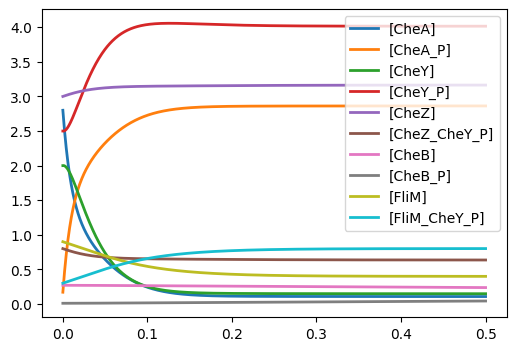

In [37]:
# Simulation parameters
simulation_round = 100 # Rounds
time_start = 0         # Start time
time_end = 0.5         # End time
time_points = 1000     # Sample points

# Visualization
r.reset()
s = r.simulate(time_start, time_end, time_points)
r.plot(s)
te.show()

This graph demonstrates the default state of the cell. When neither attractant nor repellent is present, the cell has high CheA autophosphorylation. CheA\~P will then phosphorylate CheY. This leads to high Flim-CheY\~P amount. This indicates that the cell has CW flagella rotation and is tumbling, which is the default mode for *E. coli*.

## Graph 2 (Attractant present, α=0)

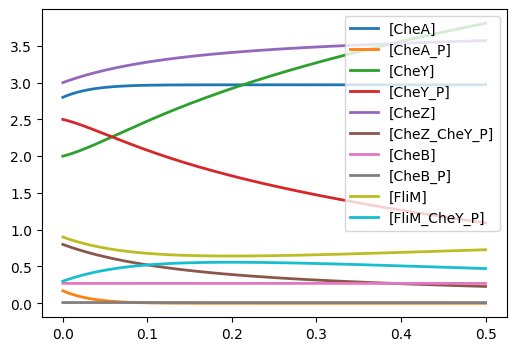

In [40]:
# Attractant present
results = []
r.reset()
r.alpha = 0
s = r.simulate(time_start, time_end, time_points)
r.plot(s)
te.show()
te.show()

This graph demonstrates what happens when attractant is present. The MCPs will bind to the attractant, and lower the level of CheA autophosphorylation. This leads to low CheY phosphorylation, and result in low FliM-CheY\~P. The change will make the flagella rotate CCW, switching the movement into running to move toward the attractant.

## Graph 3 (Repellent present, α=1)

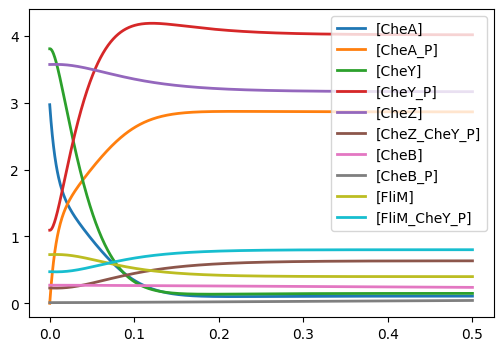

In [41]:
# Repellent present
r.alpha = 1
s = r.simulate(time_start, time_end, time_points)
r.plot(s)
te.show()

This graph demonstrates what happens when repellent is present. Repellent will increase the level of CheA autophosphorylation. The graph started with the *E. coli* cell in running state. We can see the FliM-CheY\~P ratio increasing again. This will switch the flagella rotation from CCW to CW, and the cell will start tumbling to avoid the repellent.

## Summary

The model above does simulate how the cell would react under different conditions (i.e., it gives correct results). However, the parameters may be different from real-world values. In general, it can be a good sample model giving a very basic understanding of the changes in *E. coli* chemotaxis system under different environmental conditions.

## Reference
Bitbol, A., & Wingreen, N. S. (2015). Fundamental constraints on the abundances of chemotaxis proteins. *Biophysical Journal*, 108(5), 1293–1305. https://doi.org/10.1016/j.bpj.2015.01.024

Medley et al. (2018). "Tellurium notebooks—An environment for reproducible dynamical modeling in systems biology." *PLoS Computational Biology*, 14(6), e1006220.

Choi et al. (2018). "Tellurium: An extensible python-based modeling environment for systems and synthetic biology." *Biosystems*, 171, 74-79.